## Part 0: Import Libraries

In [79]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

## Part 1: Importing the data

In [80]:
facebook = pd.read_csv("static/FB.csv")

In [81]:
facebook.set_index("Date", inplace=True)

In [82]:
facebook.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


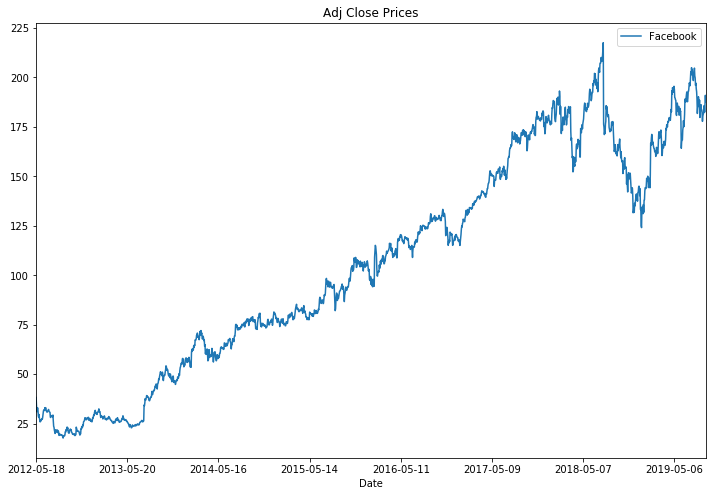

In [156]:
facebook["Adj Close"].plot(label="Facebook", figsize=(12,8),title="Adj Close Prices")
plt.legend();

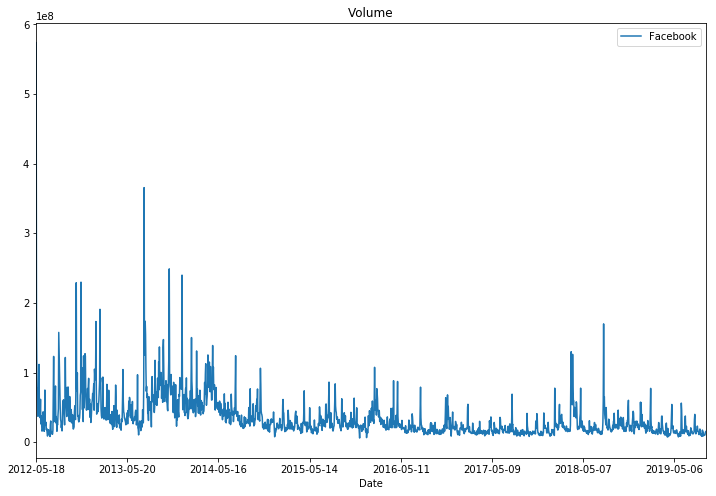

In [157]:
facebook["Volume"].plot(label="Facebook", figsize=(12,8),title="Volume")
plt.legend();

* Interesting, looks like Facebook has a spike somewhere in late 2012

In [158]:
facebook["Volume"].max()

573576400

In [159]:
facebook["Volume"].argmax()

'2012-05-18'

When we search about that date we saw it was the date of Facebook IPO - https://money.cnn.com/2012/05/18/technology/facebook-ipo-trading/index.htm

** Then I tried to create some more features. a "Total Traded" column which is Open Price multiplied by the Volume trade **

In [87]:
facebook["Total Traded"] = facebook["Open"]*facebook["Volume"]

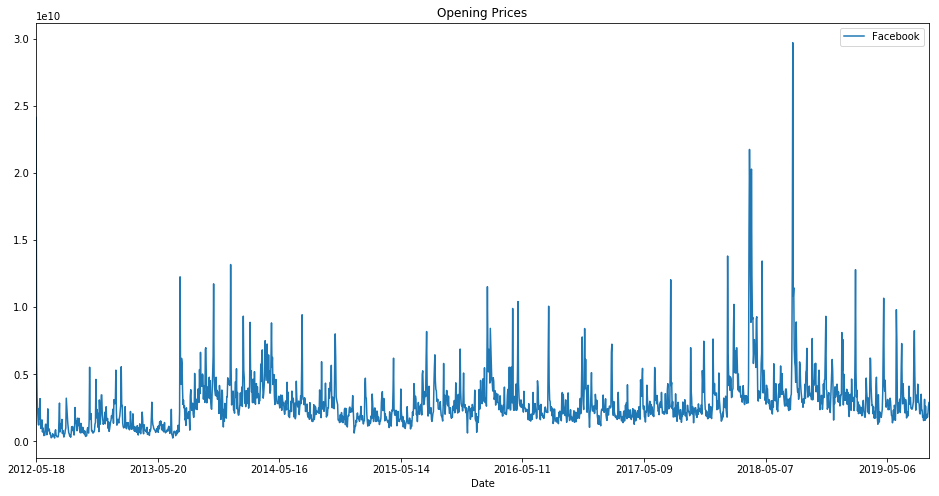

In [88]:
facebook["Total Traded"].plot(label="Facebook", figsize=(16,8),title="Opening Prices")
plt.legend();

Something happened for facebook at 2018. There is spike for Total Trade

In [89]:
facebook["Total Traded"].max()

29696968923.196297

In [90]:
facebook["Total Traded"].argmax()

'2018-07-26'

the company missed projections on key metrics after struggling with data leaks and fake news scandals. - https://www.cnbc.com/2018/07/26/facebook-is-on-pace-for-its-worst-day-ever.html

Then I used MA (Moving Averages) to reduce to noise and see the trend better.

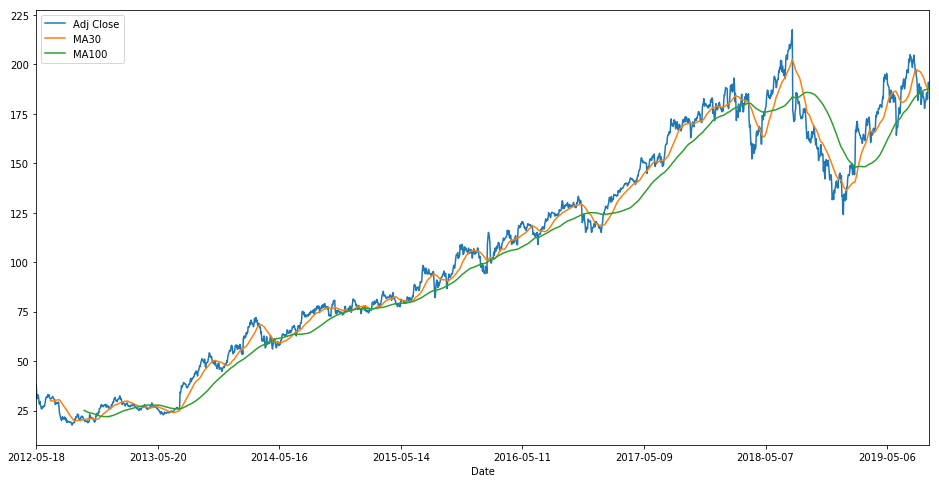

In [91]:
facebook["MA30"] = facebook["Adj Close"].rolling(window=30).mean()
facebook["MA100"] = facebook["Adj Close"].rolling(window=100).mean()
facebook[["Adj Close", "MA30", "MA100"]].plot(figsize=(16,8))

### Part 3: Basic Financial Analysis

#### Daily Percentage Change

r_t = (p_t / (p_t-1) ) - 1

This defines return at time t as equal to the price at the time t divided by the price at time t-1 minus 1. This is helpful to analyzing the volatility of the stock. 

In [92]:
facebook["returns"] = facebook["Close"].pct_change(1)

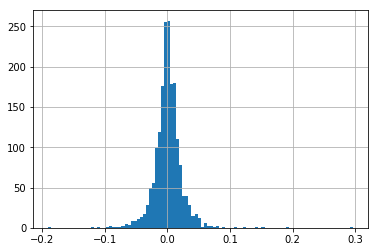

In [93]:
facebook["returns"].hist(bins=100);

### Cumulative Daily Returns
We can see which stock was the most wide ranging in daily returns.

With daily cumulative returns, the question we are trying to answer is the following, if I invested 1 usd in the company at the beginning of time series, how much would is be worth today? This is different than just the stock price at the current day, because it will take into account the daily returns.

df[daily_cumulative_return] = (1 + df[pct_daily_return]).cumprod()

In [94]:
facebook["Cumulative Return"] = (1+facebook["returns"]).cumprod()

In [161]:
facebook.index = pd.to_datetime(facebook.index)

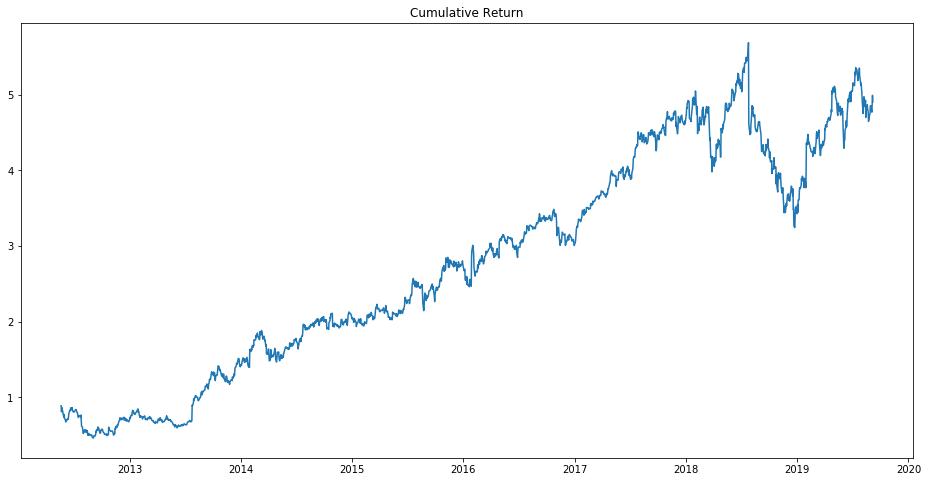

In [165]:
plt.figure(figsize=(16,8))
plt.title("Cumulative Return")
plt.plot(facebook["Cumulative Return"])

In [166]:
facebook.corr()

,Open,High,Low,Close,Adj Close,Volume,Total Traded,MA30,MA100,returns,Cumulative Return
Open,1.000000,0.999797,0.999724,0.999535,0.999535,-0.449955,0.283578,0.994310,0.981438,-0.015109,0.999536
High,0.999797,1.000000,0.999682,0.999766,0.999766,-0.445842,0.289132,0.994601,0.982242,-0.007492,0.999769
Low,0.999724,0.999682,1.000000,0.999795,0.999795,-0.455724,0.273871,0.993672,0.980424,-0.005044,0.999795
Close,0.999535,0.999766,0.999795,1.000000,1.000000,-0.451143,0.280846,0.994009,0.981126,0.002697,1.000000
Adj Close,0.999535,0.999766,0.999795,1.000000,1.000000,-0.451143,0.280846,0.994009,0.981126,0.002697,1.000000
Volume,-0.449955,-0.445842,-0.455724,-0.451143,-0.451143,1.000000,0.551611,-0.481777,-0.497174,0.125106,-0.483198
Total Traded,0.283578,0.289132,0.273871,0.280846,0.280846,0.551611,1.000000,0.303425,0.265978,-0.006447,0.296636
MA30,0.994310,0.994601,0.993672,0.994009,0.994009,-0.481777,0.303425,1.000000,0.990773,-0.032579,0.994009
MA100,0.981438,0.982242,0.980424,0.981126,0.981126,-0.497174,0.265978,0.990773,1.000000,-0.051608,0.981126
returns,-0.015109,-0.007492,-0.005044,0.002697,0.002697,0.125106,-0.006447,-0.032579,-0.051608,1.000000,0.002697


I checked the correlation. This is helpful to choose predictor variables.

### Part 4 Machine Learning

While splitting the data into train and validation set, we cannot use random splitting since that will destroy the time component. So here we have set %5 of  data into test and the rest for training.

In [167]:
print("Number of data points in Facebook dataset: {}".format(len(facebook)))

Number of data points in Facebook dataset: 1837


### Linear Regression

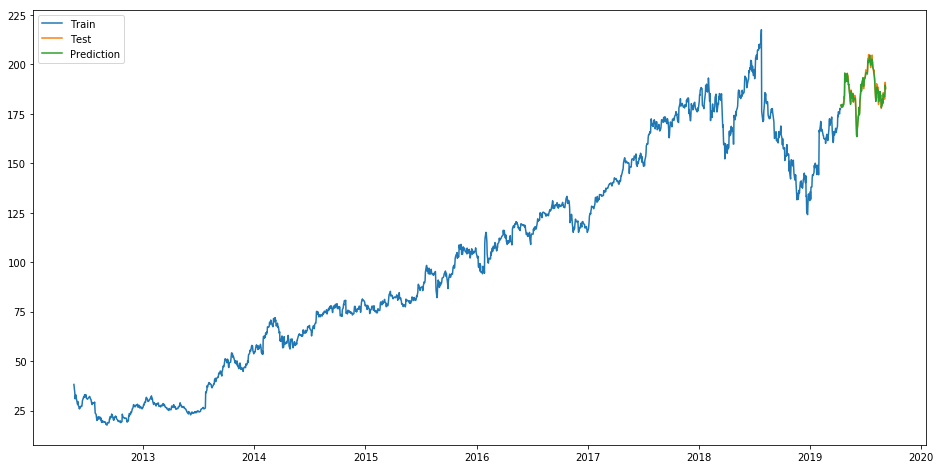

In [168]:
train = facebook[["Adj Close","Volume", "Total Traded", "Low"]].iloc[:1735].dropna()
test = facebook[["Adj Close","Volume", "Total Traded", "Low"]].iloc[1735:].dropna()

x_train = train.drop("Adj Close", axis=1)
y_train = train["Adj Close"]

x_test = test.drop("Adj Close", axis=1)
y_test = test["Adj Close"]

model_linear = LinearRegression()
model_linear.fit(x_train,y_train)

preds_linear = model_linear.predict(x_test)

test['Predictions Linear'] = 0
test['Predictions Linear'] = preds_linear

test.index = pd.to_datetime(test.index)
train.index = pd.to_datetime(train.index)

plt.figure(figsize=(16,8))
plt.plot(train["Adj Close"])
plt.plot(test[['Adj Close', 'Predictions Linear']])
plt.legend(labels=["Train", "Test", "Prediction"]);

In [169]:
# The coefficients
print('Coefficients: \n', model_linear.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, preds_linear))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, preds_linear))

Coefficients: 
 [ -4.78153419e-09   2.60035601e-10   1.00442788e+00]
Mean squared error: 2.21
Variance score: 0.97


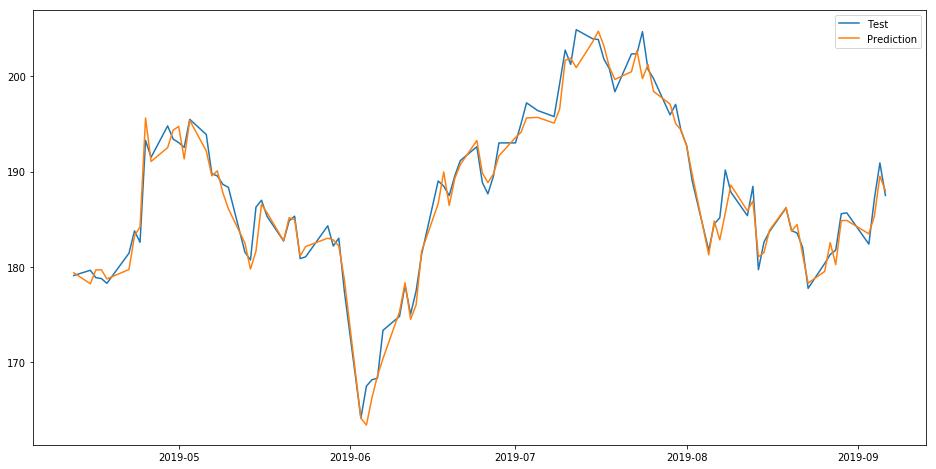

In [170]:
plt.figure(figsize=(16,8))
plt.plot(test[['Adj Close', 'Predictions Linear']])
plt.legend(labels=["Test", "Prediction"]);

### Ridge Regression

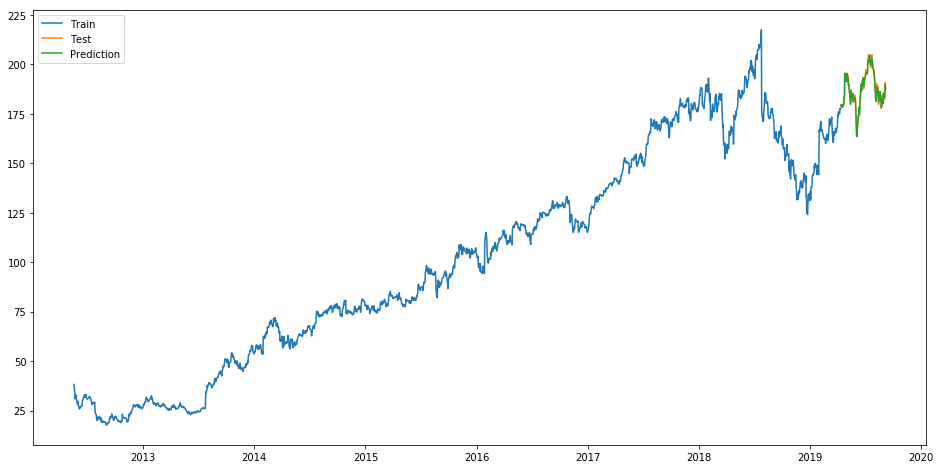

In [171]:
train = facebook[["Adj Close","Volume", "Total Traded", "Low"]].iloc[:1735].dropna()
test = facebook[["Adj Close","Volume", "Total Traded", "Low"]].iloc[1735:].dropna()

x_train = train.drop("Adj Close", axis=1)
y_train = train["Adj Close"]

x_test = test.drop("Adj Close", axis=1)
y_test = test["Adj Close"]

model_ridge = Ridge()
model_ridge.fit(x_train,y_train)

preds_ridge = model_ridge.predict(x_test)

test['Predictions Ridge'] = 0
test['Predictions Ridge'] = preds_ridge

test.index = pd.to_datetime(test.index)
train.index = pd.to_datetime(train.index)

plt.figure(figsize=(16,8))
plt.plot(train["Adj Close"])
plt.plot(test[['Adj Close', 'Predictions Ridge']])
plt.legend(labels=["Train", "Test", "Prediction"]);

In [172]:
# The coefficients
print('Coefficients: \n', model_ridge.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, preds_ridge))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, preds_ridge))


Coefficients: 
 [ -4.78233473e-09   2.60046178e-10   1.00442734e+00]
Mean squared error: 2.21
Variance score: 0.97


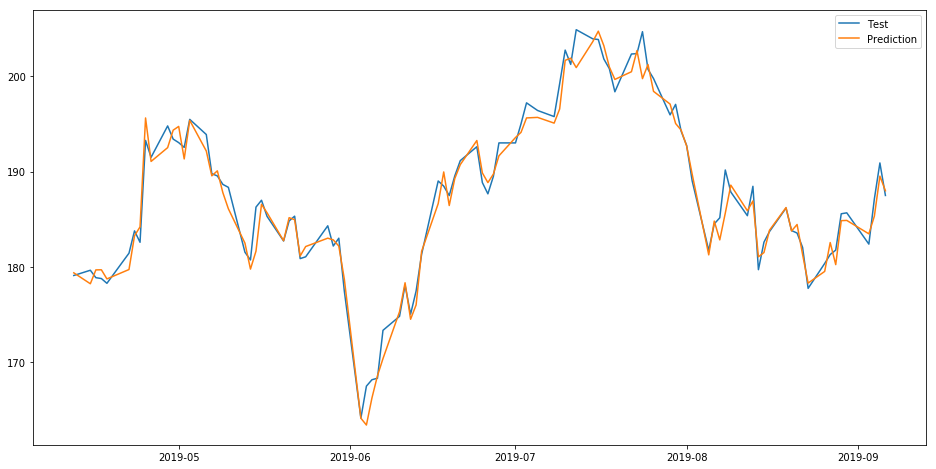

In [173]:
plt.figure(figsize=(16,8))
plt.plot(test[['Adj Close', 'Predictions Ridge']])
plt.legend(labels=["Test", "Prediction"]);

### Lasso Regression

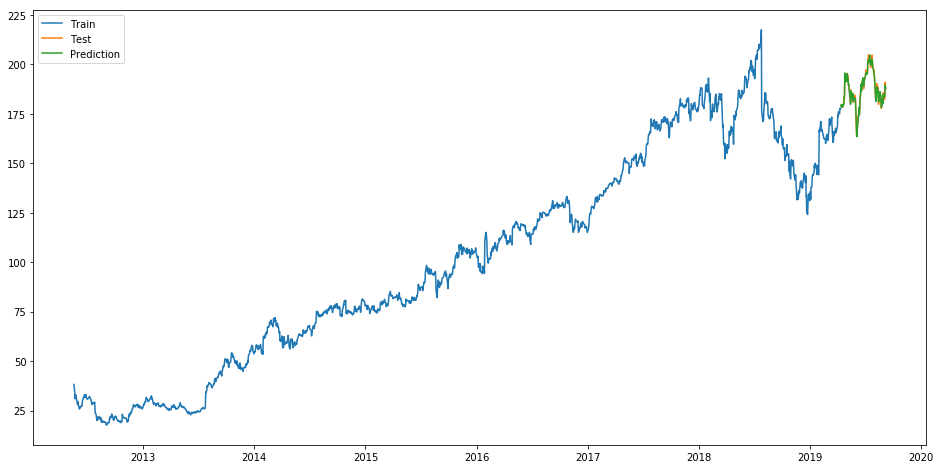

In [174]:
train = facebook[["Adj Close","Volume", "Total Traded", "Low"]].iloc[:1735].dropna()
test = facebook[["Adj Close","Volume", "Total Traded", "Low"]].iloc[1735:].dropna()

x_train = train.drop("Adj Close", axis=1)
y_train = train["Adj Close"]

x_test = test.drop("Adj Close", axis=1)
y_test = test["Adj Close"]

model_lasso = Lasso()
model_lasso.fit(x_train,y_train)

preds_lasso = model.predict(x_test)

test['Predictions Lasso'] = 0
test['Predictions Lasso'] = preds_lasso

test.index = pd.to_datetime(test.index)
train.index = pd.to_datetime(train.index)

plt.figure(figsize=(16,8))
plt.plot(train["Adj Close"])
plt.plot(test[['Adj Close', 'Predictions Lasso']])
plt.legend(labels=["Train", "Test", "Prediction"]);

In [175]:
# The coefficients
print('Coefficients: \n', model_lasso.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, preds_lasso))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, preds_lasso))

Coefficients: 
 [ -6.16434634e-09   2.78305363e-10   1.00350448e+00]
Mean squared error: 2.25
Variance score: 0.97


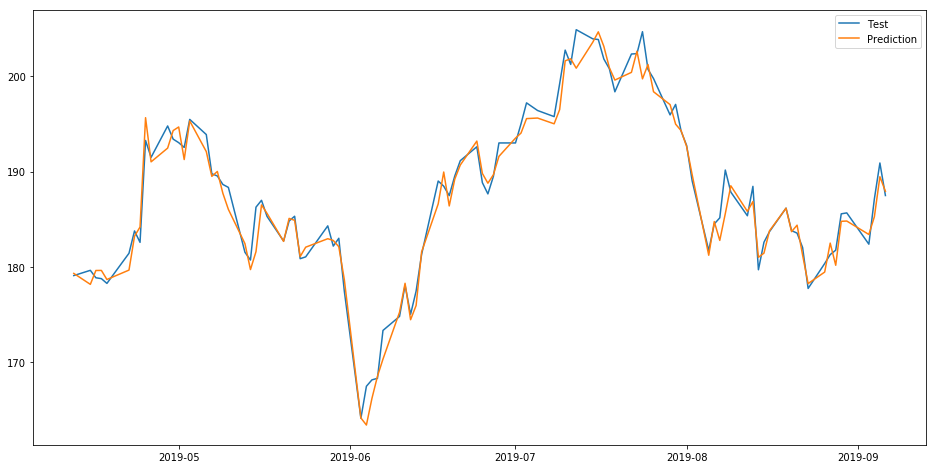

In [176]:
plt.figure(figsize=(16,8))
plt.plot(test[['Adj Close', 'Predictions Lasso']])
plt.legend(labels=["Test", "Prediction"]);